# Setup

To run this notebook on Colab, a few setup steps are required. Follow along step by step:

1. **Clone the `dlfb` library**  
   First, clone the repository that contains the `dlfb` library.

In [2]:
%cd /content
!rm -rf ./dlfb-clone/
!git clone "https://github.com/deep-learning-for-biology/dlfb.git" dlfb-clone --branch main
%cd dlfb-clone

/content
Cloning into 'dlfb-clone'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 121 (delta 19), reused 111 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (121/121), 62.31 KiB | 5.66 MiB/s, done.
Resolving deltas: 100% (19/19), done.
/content/dlfb-clone


2. **Install dependencies**  
   Once the library is cloned, install the required dependencies.

In [2]:
%%bash
curl -LsSf https://astral.sh/uv/install.sh | sh && \
export PATH="/root/.local/bin:${PATH}" && \
uv pip compile ./requirements/{base,dlfb,cancer,gpu}.txt \
  --color never \
  --constraint ./requirements/constraints.txt | \
uv pip install -r - --system

no checksums to verify
installing to /usr/local/bin
  uv
  uvx
everything's installed!


downloading uv 0.9.11 x86_64-unknown-linux-gnu
Resolved 101 packages in 790ms
Using Python 3.12.12 environment at: /usr
Resolved 101 packages in 269ms
Prepared 53 packages in 10.21s
Uninstalled 39 packages in 656ms
Installed 53 packages in 141ms
 - absl-py==1.4.0
 + absl-py==2.3.1
 + adjusttext==1.3.0
 - cachetools==5.5.2
 + cachetools==6.2.2
 - certifi==2025.10.5
 + certifi==2022.12.7
 - charset-normalizer==3.4.4
 + charset-normalizer==2.1.1
 - click==8.3.0
 + click==8.1.8
 + dlfb==0.1.1 (from file:///content/dlfb-clone)
 + dm-pix==0.4.4
 - filelock==3.20.0
 + filelock==3.19.1
 - flax==0.10.7
 + flax==0.10.4
 - fsspec==2025.3.0
 + fsspec==2025.9.0
 - google-auth==2.38.0
 + google-auth==2.43.0
 - google-cloud-storage==2.19.0
 + google-cloud-storage==3.0.0
 - google-resumable-media==2.7.2
 + google-resumable-media==2.8.0
 - idna==3.11
 + idna==3.4
 + ipinfo==5.1.1
 - jax==0.7.2
 + jax==0.5.1
 - jax-cuda12-pjrt==0.7.2
 + jax-cuda12-pjrt==0.5.1
 - jax-cuda12-plugin==0.7.2
 + jax-cuda12-pl

3. **Providion the datasets**  
   You’ll then need to access and download the necessary datasets for this chapter.

In [3]:
# from google.colab import auth

# auth.authenticate_user()
# # NOTE: exclude models with '--no-models' flag
!dlfb-provision --chapter cancer

Files Downloaded: 100% 3033/3033 [00:07<00:00, 398.35file/s]


4. **Load the `dlfb` package**  
   Finally, load the `dlfb` package.  
   - ⚠️ Note: Loading can sometimes be finicky. If you encounter issues, simply **restart the runtime**. All previously downloaded data and installed packages will persist, so you can re-run the load step without repeating everything.

In [4]:
# Toggle JAX_DISABLE_JIT to True for easier debugging
%env JAX_DISABLE_JIT=False

try:
  import dlfb
except ImportError as exc:
  # NOTE: Packages installed in editable mode are not immediately
  #       recognized by Colab (https://stackoverflow.com/a/63312333).
  import site
  site.main()
  import dlfb

import random
import numpy as np
from dlfb.utils.display import display

seed = 42
random.seed(seed)
np.random.seed(seed)

env: JAX_DISABLE_JIT=False


# 5. Detecting Skin Cancer in Medical Images


## 5.1. Biology Primer
### 5.1.1. Skin Cancer
### 5.1.2. Causes and Risk Factors
### 5.1.3. How Skin Cancer Is Diagnosed
### 5.1.4. Image-Based Skin Cancer Detection


## 5.2. Machine Learning Primer
### 5.2.1. Convolutional Neural Networks
### 5.2.2. Understanding a Convolution
### 5.2.3. Understanding Dimensions
### 5.2.4. Pooling
### 5.2.5. Other Components of a CNN
### 5.2.6. ResNets


## 5.3. Exploring the Data
### 5.3.1. A First Glimpse


In [5]:
import re
from pathlib import Path

from dlfb.utils.context import assets

image_file = next(Path(assets("cancer/datasets/raw")).rglob("*.jpg"))

print(rf"One of the images: {re.sub('^.*?datasets/', '', str(image_file))}")

One of the images: raw/Test/basal cell carcinoma/ISIC_0024436.jpg


In [6]:
import pandas as pd


def load_metadata(data_dir: str) -> pd.DataFrame:
  metadata = []
  for path in Path(data_dir).rglob("*.jpg"):
    split, class_name, _ = path.parts[-3:]
    metadata.append(
      {
        "split_orig": split,
        "class_orig": class_name,
        "full_path": str(path),
      }
    )
  return pd.DataFrame(metadata).rename_axis("frame_id").reset_index()


metadata = load_metadata(assets("cancer/datasets/raw"))
print(metadata)

      frame_id split_orig            class_orig  \
0            0       Test  basal cell carcinoma   
1            1       Test  basal cell carcinoma   
2            2       Test  basal cell carcinoma   
3            3       Test  basal cell carcinoma   
4            4       Test  basal cell carcinoma   
...        ...        ...                   ...   
2352      2352      Train                 nevus   
2353      2353      Train                 nevus   
2354      2354      Train                 nevus   
2355      2355      Train                 nevus   
2356      2356      Train                 nevus   

                                              full_path  
0     /content/assets/cancer/datasets/raw/Test/basal...  
1     /content/assets/cancer/datasets/raw/Test/basal...  
2     /content/assets/cancer/datasets/raw/Test/basal...  
3     /content/assets/cancer/datasets/raw/Test/basal...  
4     /content/assets/cancer/datasets/raw/Test/basal...  
...                                    

In [7]:
counts = pd.crosstab(
  metadata["class_orig"], metadata["split_orig"], margins=True
)
print(counts)

split_orig                  Test  Train   All
class_orig                                   
actinic keratosis             16    114   130
basal cell carcinoma          16    376   392
dermatofibroma                16     95   111
melanoma                      16    438   454
nevus                         16    357   373
pigmented benign keratosis    16    462   478
seborrheic keratosis           3     77    80
squamous cell carcinoma       16    181   197
vascular lesion                3    139   142
All                          118   2239  2357


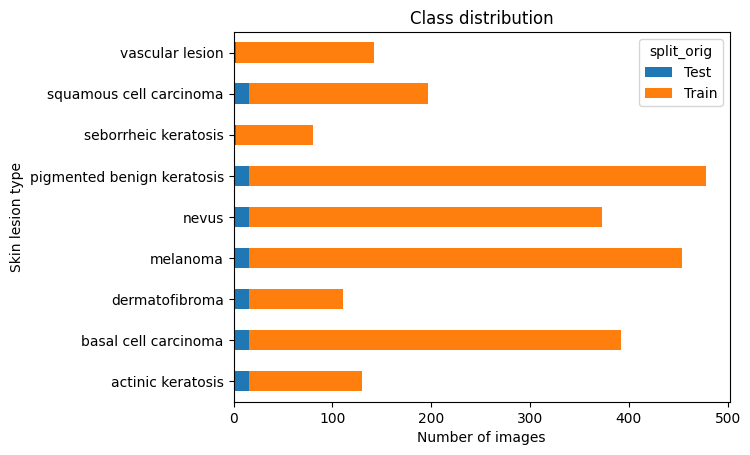

In [8]:
fig = counts.drop(["All"], axis=1).drop(["All"], axis=0).plot.barh(stacked=True)
fig.set_xlabel("Number of images")
fig.set_ylabel("Skin lesion type")
fig.set_title("Class distribution");

Problems with the dataset:
- Class imbalance
- Small test set
- No validation set

We will apply data augmentation and resampling to address these issue later.

### 5.3.2. Previewing the Images


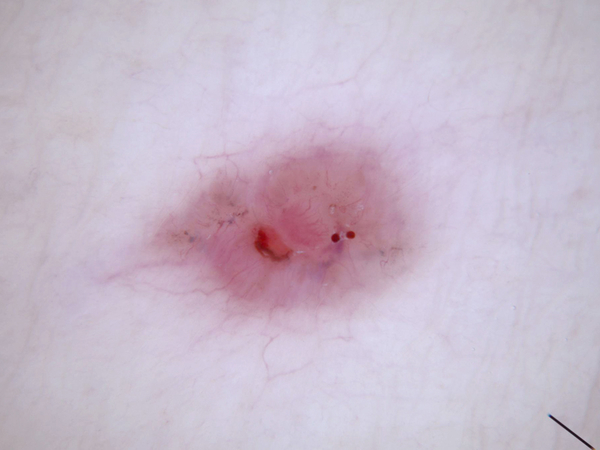

In [9]:
from PIL import Image

Image.open(metadata["full_path"].iloc[0])

In [10]:
import matplotlib.pyplot as plt


def show_random_image(metadata: pd.DataFrame, class_name: str) -> plt.Figure:
  record = (
    metadata[metadata["class_orig"] == class_name]
    .sample(1)
    .to_dict(orient="records")[0]
  )
  fig = plt.figure(figsize=(4, 4))
  plt.imshow(Image.open(record["full_path"]))
  plt.title(record["class_orig"].capitalize())
  return fig

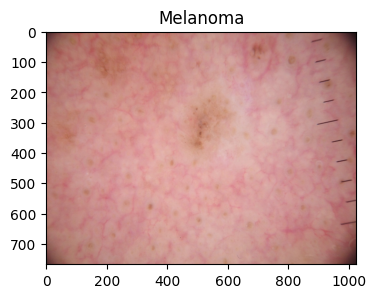

In [11]:
show_random_image(metadata, "melanoma");

In [12]:
def plot_random_image_grid(
  metadata: pd.DataFrame, ncols: int = 3
) -> plt.Figure:
  """Display a random example image from each class in a grid."""
  records = metadata.groupby("class_orig").sample(1).to_dict(orient="records")
  nrows = (len(records) + ncols - 1) // ncols
  fig, axes = plt.subplots(nrows, ncols, figsize=(10, 2.5 * nrows))
  axes = axes.flatten()

  for record, ax in zip(records, axes):
    ax.imshow(Image.open(record["full_path"]))
    ax.set_title(record["class_orig"].capitalize())
    ax.axis("off")

  plt.tight_layout()
  return fig

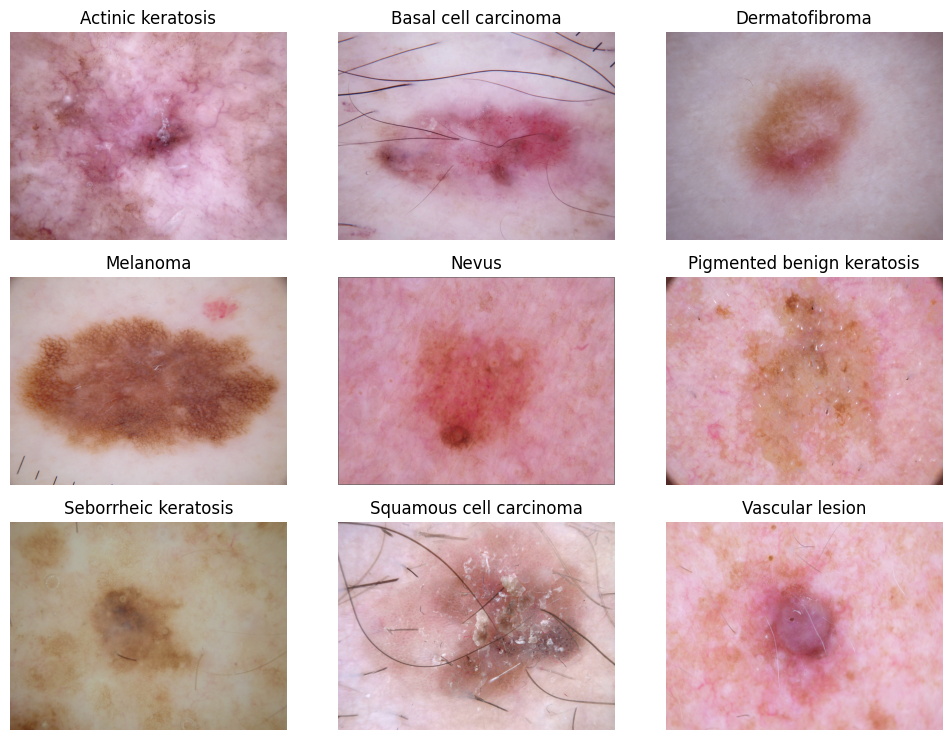

In [13]:
plot_random_image_grid(metadata);

### 5.3.3. Addressing Dataset Issues


Resample train, valid, and test set using 0.7:0.2:0.1 ratio

In [14]:
import numpy as np

np.random.seed(seed=42)
splits = {"train": 0.7, "valid": 0.20, "test": 0.10}

metadata["split"] = np.random.choice(
  list(splits.keys()), p=list(splits.values()), size=metadata.shape[0]
)

counts = pd.crosstab(metadata["class_orig"], metadata["split"], margins=True)
print(counts)

split                       test  train  valid   All
class_orig                                          
actinic keratosis             17     92     21   130
basal cell carcinoma          44    270     78   392
dermatofibroma                 9     81     21   111
melanoma                      40    333     81   454
nevus                         36    260     77   373
pigmented benign keratosis    49    329    100   478
seborrheic keratosis           4     59     17    80
squamous cell carcinoma       20    135     42   197
vascular lesion               12     96     34   142
All                          231   1655    471  2357


Visualize the new split

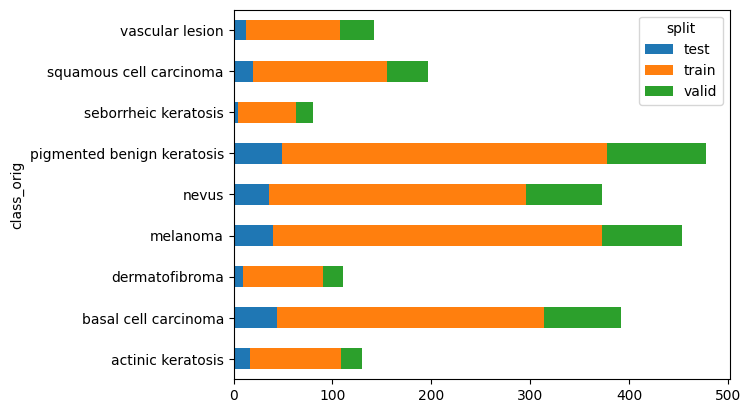

In [15]:
counts.drop(["All"], axis=1).drop(["All"], axis=0).plot.barh(stacked=True);

#### 5.3.3.1. Balancing the Batches
#### 5.3.3.2. Augmenting the Dataset


Goal: make the training dataset balanced so that the model has equal exposure to all classes, while keep the valid and test set as it is so that it reflects real-world scenarios.

In [18]:
# # Install a compatible NumPy version to resolve conflicts.
!pip install numpy==1.26.4 --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 72.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.2
    Uninstalling numpy-2.1.2:
      Successfully uninstalled numpy-2.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.4 requires packaging>=24.2.0, but you have packaging 24.1 which is incompatible.
bigframes 2.28.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.33.1 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version

In [1]:
from dlfb.cancer.train.handlers.augmentors import rich_augmentor

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/resnet-18 were not used when initializing FlaxResNetModel: {('params', 'encoder', 'stages', '0', 'layers', '1', 'layer', '1', 'convolution', 'kernel'), ('params', 'encoder', 'stages', '0', 'layers', '0', 'layer', '1', 'normalization', 'bias'), ('batch_stats', 'encoder', 'stages', '2', 'layers', '1', 'layer', '1', 'normalization', 'mean'), ('batch_stats', 'encoder', 'stages', '1', 'layers', '0', 'layer', '0', 'normalization', 'mean'), ('batch_stats', 'encoder', 'stages', '0', 'layers', '0', 'layer', '0', 'normalization', 'var'), ('params', 'encoder', 'stages', '2', 'layers', '0', 'layer', '1', 'normalization', 'bias'), ('batch_stats', 'encoder', 'stages', '0', 'layers', '1', 'layer', '0', 'normalization', 'mean'), ('params', 'encoder', 'stages', '2', 'layers', '1', 'layer', '1', 'convolution', 'kernel'), ('batch_stats', 'encoder', 'stages', '2', 'layers', '1', 'layer', '1', 'normalization', 'var'), ('batch_stats', 'encoder', 'stages', '2

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/resnet-34 were not used when initializing FlaxResNetModel: {('params', 'encoder', 'stages', '0', 'layers', '1', 'layer', '1', 'convolution', 'kernel'), ('batch_stats', 'encoder', 'stages', '2', 'layers', '2', 'layer', '0', 'normalization', 'mean'), ('batch_stats', 'encoder', 'stages', '0', 'layers', '2', 'layer', '0', 'normalization', 'mean'), ('batch_stats', 'encoder', 'stages', '3', 'layers', '2', 'layer', '1', 'normalization', 'var'), ('batch_stats', 'encoder', 'stages', '1', 'layers', '2', 'layer', '1', 'normalization', 'mean'), ('batch_stats', 'encoder', 'stages', '1', 'layers', '2', 'layer', '0', 'normalization', 'mean'), ('params', 'encoder', 'stages', '0', 'layers', '2', 'layer', '0', 'convolution', 'kernel'), ('batch_stats', 'encoder', 'stages', '0', 'layers', '2', 'layer', '1', 'normalization', 'var'), ('params', 'encoder', 'stages', '0', 'layers', '0', 'layer', '1', 'normalization', 'bias'), ('batch_stats', 'encoder', 'stages

config.json: 0.00B [00:00, ?B/s]

flax_model.msgpack:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [ ]:
display([rich_augmentor])
# deepmind pix library (jax.jit compatible)
# images are randomly transformed with a fixed probability

@jax.jit
def rich_augmentor(image: jax.Array, rng: jax.Array) -> jax.Array:
  """Applies random flips, brightness, contrast, hue changes, and rotation."""
  image = pix.random_flip_left_right(rng, image)
  image = pix.random_flip_up_down(rng, image)
  image = pix.random_brightness(rng, image, max_delta=0.1)
  image = pix.random_contrast(rng, image, lower=0.9, upper=1)
  image = pix.random_hue(rng, image, max_delta=0.05)
  # Angles are provided in radians, i.e. +/- 10 degrees.
  image = pix.rotate(
    image,
    angle=jax.random.uniform(rng, shape=(), minval=-0.174533, maxval=0.174533),
  )
  return image

Test augmentation

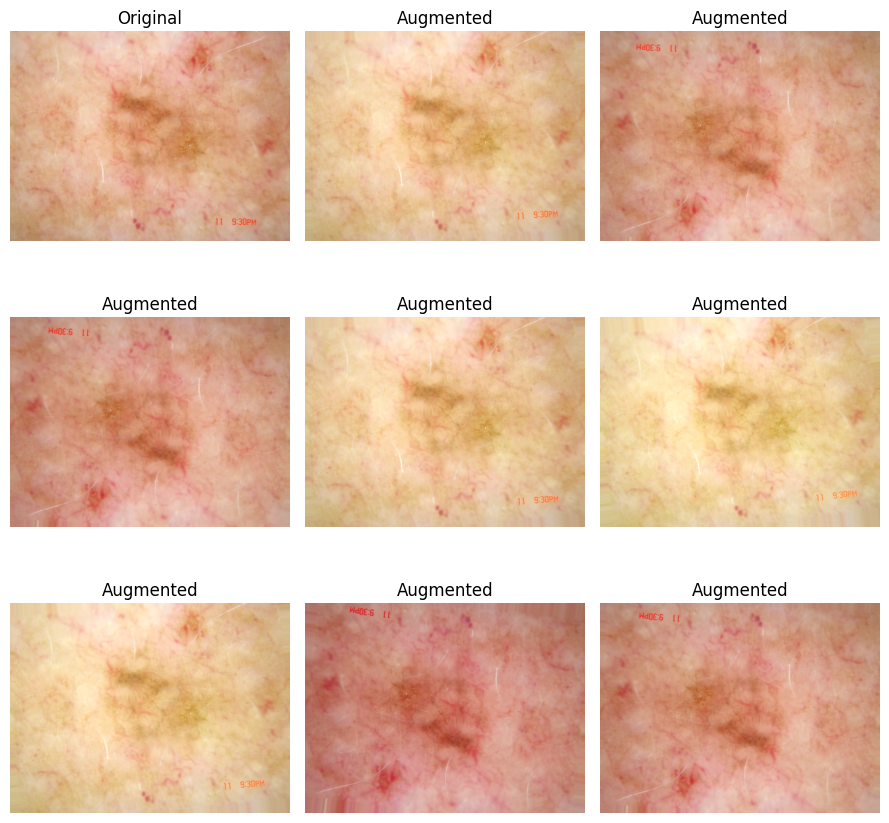

In [17]:
import jax
import jax.numpy as jnp

rng = jax.random.PRNGKey(seed=42)
image = Image.open(
  metadata[metadata["class_orig"] == "melanoma"]
  .sample(1)["full_path"]
  .values[0]
)

_, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.flatten()
axes[0].imshow(image)
axes[0].set_title("Original")
axes[0].axis("off")
image = jnp.asarray(image) / 255.0
for ax in axes[1:]:
  rng, rng_augment = jax.random.split(rng, num=2)
  ax.imshow(rich_augmentor(image, rng_augment))
  ax.set_title("Augmented")
  ax.axis("off")
plt.tight_layout()

#### 5.3.3.3. Preprocessing the Images


Preprocessing ensures that input data shares similar pixel dynamic range, aspect ratio, and resolution.

The following steps include:
- Resize image (short side 256 pixel, keep aspect ratio)
- Crop a square image from center
- Min-max intensity scaling

In [18]:
from dlfb.cancer.dataset.preprocessors import (
  center_crop,
  resize_preserve_aspect,
)

display([resize_preserve_aspect, center_crop])

def resize_preserve_aspect(
  image: jax.Array, short_side: int = 256
) -> jax.Array:
  """Resize image with shorter side is `short_side`, keeping aspect ratio."""
  h, w, c = image.shape
  scale = short_side / jnp.minimum(h, w)
  new_h = jnp.round(h * scale).astype(jnp.int32)
  new_w = jnp.round(w * scale).astype(jnp.int32)
  resized = jax.image.resize(image, (new_h, new_w, c), method="bilinear")
  return resized


def center_crop(image: jax.Array, size: int = 224) -> jax.Array:
  """Crop the center square of given size from an image."""
  h, w, _ = image.shape
  top = (h - size) // 2
  left = (w - size) // 2
  return image[top : top + size, left : left + size]

In [19]:
from dlfb.cancer.dataset.preprocessors import rescale_image

display([rescale_image])

def rescale_image(image: jax.Array) -> jax.Array:
  """Normalizes pixel values to the [0, 1] range by dividing by 255."""
  return image / 255.0

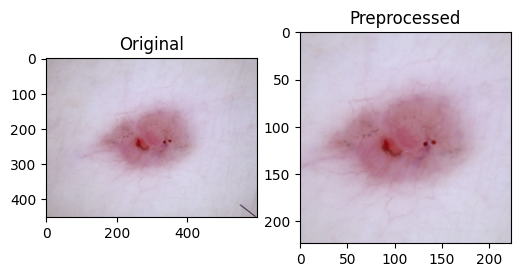

In [20]:
original_image = Image.open(metadata.iloc[0]["full_path"])
image = np.array(original_image)
image = resize_preserve_aspect(image)
image = center_crop(image)
image = rescale_image(image)

_, axes = plt.subplots(1, 2, figsize=(6, 3))
axes = axes.flatten()
axes[0].imshow(original_image)
axes[0].set_title("Original")
axes[1].imshow(image)
axes[1].set_title("Preprocessed");

#### 5.3.3.4. Data Storage with Memory-Mapped Arrays


To speed up data preprocessing and avoid wasting memory, we preprocess images and store them into hard disk.
During training, we just need to extract images from the memory-mapped arrays.

In [21]:
from tempfile import TemporaryFile
# tempfile provide a way to create temporary files and directories so that
# we can store data temporarily without using permanent disk space.

images_on_disk = np.memmap(
  TemporaryFile(), dtype="float32", mode="w+", shape=(10, 224, 224, 3)
)
for i, full_path in enumerate(metadata[:10]["full_path"]):
  image = Image.open(full_path)
  image = np.array(image)
  image = resize_preserve_aspect(image)
  image = center_crop(image)
  image = rescale_image(image)
  images_on_disk[i, :, :, :] = image
images_on_disk.flush()

### 5.3.4. Building a DatasetBuilder


In [23]:
from dlfb.cancer.dataset.builder import DatasetBuilder

display([DatasetBuilder])
# MetadataLoader builds class/split information
# ImageLoader handles data preprocessing and loading images from disk
# class_map indicates multi-class classification or binary classification

class DatasetBuilder:
  """Builds a dataset with metadata, loaded images, and class mappings."""

  def __init__(self, data_dir: str, out_dir: str | None = None) -> None:
    self.data_dir = data_dir
    self.out_dir = out_dir or data_dir

  def build(
    self,
    rng: jax.Array,
    splits: dict[str, float],
    preprocessors: list[Callable] = [crop],
    image_size: tuple[int, int, int] = (224, 224, 3),
    class_map: dict[str, Any] | None = None,
  ) -> dict[str, Dataset]:
    """Builds the dataset splits from loaded metadata and loaded images."""
    metadata = MetadataLoader(self.data_dir, self.out_dir).load(class_map)
    images = ImageLoader(metadata, self.out_dir).load(preprocessors, image_size)

    # Shuffle the dataset and assign each example to one of the dataset splits.
    num_samples = len(metadata)
    rng, rng_perm = jax.random.split(rng, 2)
    shuffled_indices = jax.random.permutation(rng_perm, num_samples)

    # Create each dataset split using the shuffled indices and store the
    # corresponding metadata and image data in a Dataset object.
    dataset_splits, start = {}, 0
    for name, size in self._get_split_sizes(splits, num_samples):
      indices = np.array(shuffled_indices[start : (start + size)])
      dataset_splits[name] = Dataset(
        metadata=metadata.iloc[indices],
        images=images,
        num_classes=metadata["class"].nunique(),
      )
      start += size
    return dataset_splits

  def _get_split_sizes(self, splits: dict[str, float], num_samples: int):
    """Convert fractional split sizes to integer counts that sum to total."""
    names = list(splits)
    sizes = [int(num_samples * splits[name]) for name in names[:-1]]
    sizes.append(num_samples - sum(sizes))  # last split gets the remainder
    yield from zip(names, sizes)

#### 5.3.4.1. Loading the Metadata and Images


In [24]:
from dlfb.cancer.dataset import Dataset

display([Dataset])

@dataclass
class Dataset:
  """Dataset class storing images and corresponding metadata."""

  metadata: pd.DataFrame
  images: Images
  num_classes: int

  def get_dummy_input(self) -> jax.Array:
    """Returns dummy input with the correct shape for the model."""
    return jnp.empty((1,) + self.images.size)

  def num_samples(self) -> int:
    """Returns the number of samples in the dataset."""
    return self.metadata.shape[0]

  def get_images(self, preprocessor: Callable, indices: jax.Array) -> jax.Array:
    """Returns preprocessed images for the given indices."""
    return self.images.loaded[preprocessor.__name__][indices]

  def get_labels(self, indices: list[int]) -> jax.Array:
    """Returns integer class labels for the given indices."""
    return jnp.int16(self.metadata.loc[indices]["label"].values)

In [25]:
from dlfb.cancer.dataset import Images

display([Images])

@dataclass
class Images:
  """Stores image data and size information."""

  loaded: dict[str, np.memmap]
  size: tuple[int, int, int]

#### 5.3.4.2. Batching the Data


In [27]:
from dlfb.cancer.train.handlers import BatchHandler

display([BatchHandler])

class BatchHandler:
  """Helper to provide appropriately prepared batches form a dataset."""

  def __init__(
    self,
    preprocessor: Callable = crop,
    sampler: Callable = epoch_sampler,
    augmentor: Callable | None = None,
  ):
    self.preprocessor = preprocessor
    self.sampler = sampler
    self.augmentor = augmentor

  def get_batches(self, dataset: Dataset, batch_size: int, rng: jax.Array):
    """Prepare dataset batches with the requested image manipulations."""
    self._validate_batch_size(dataset, batch_size)
    rng, rng_sampler = jax.random.split(rng, num=2)

    for batch_indices in self.sampler(
      dataset.metadata, batch_size, rng_sampler
    ):
      images = dataset.get_images(self.preprocessor, batch_indices)

      if self.augmentor is not None:
        rng, rng_augment = jax.random.split(rng, 2)
        images = jax.vmap(lambda image, r: self.augmentor(image, rng=r))(
          images, jax.random.split(rng_augment, images.shape[0])
        )

      batch = {
        "frame_ids": batch_indices,
        "images": images,
        "labels": dataset.get_labels(batch_indices),
      }
      yield batch

  @staticmethod
  def _validate_batch_size(dataset: Dataset, batch_size: int) -> None:
    """Ensures that batch_size is within feasible bounds."""
    if batch_size > dataset.num_samples():
      raise ValueError(
        f"Batch size ({batch_size}) cannot be larger than dataset size "
        "({len(frame_ids)})."
      )
    if batch_size < dataset.num_classes:
      raise ValueError(
        f"batch_size ({batch_size}) has to be larger than "
        f"number of unique labels."
      )

### 5.3.5. Readying the Dataset


In [28]:
from dlfb.cancer.train.handlers.augmentors import rich_augmentor
from dlfb.cancer.train.handlers.samplers import balanced_sampler

rng = jax.random.PRNGKey(seed=42)
rng, rng_dataset = jax.random.split(rng, 2)

builder = DatasetBuilder(data_dir=assets("cancer/datasets/raw"))

dataset_splits = builder.build(
  rng=rng_dataset,
  splits={"train": 0.7, "valid": 0.20, "test": 0.10},
  image_size=(224, 224, 3),
)

print(dataset_splits["train"].metadata)

      frame_id split_orig                  class_orig  \
177        177      Train           actinic keratosis   
408        408      Train        basal cell carcinoma   
445        445      Train        basal cell carcinoma   
1454      1454      Train                       nevus   
754        754      Train                    melanoma   
...        ...        ...                         ...   
2280      2280      Train             vascular lesion   
1743      1743      Train  pigmented benign keratosis   
1579      1579      Train  pigmented benign keratosis   
1966      1966      Train        seborrheic keratosis   
305        305      Train        basal cell carcinoma   

                                              full_path  label  \
177   /content/assets/cancer/datasets/raw/Train/acti...      0   
408   /content/assets/cancer/datasets/raw/Train/basa...      1   
445   /content/assets/cancer/datasets/raw/Train/basa...      1   
1454  /content/assets/cancer/datasets/raw/Train/nev

In [29]:
rng, rng_train = jax.random.split(rng, 2)

train_batcher = BatchHandler(sampler=balanced_sampler, augmentor=rich_augmentor) # create balanced training dataset
train_batches = train_batcher.get_batches(
  dataset_splits["train"], batch_size=32, rng=rng_train
)
batch = next(train_batches)

In [30]:
batch["images"].shape

(32, 224, 224, 3)

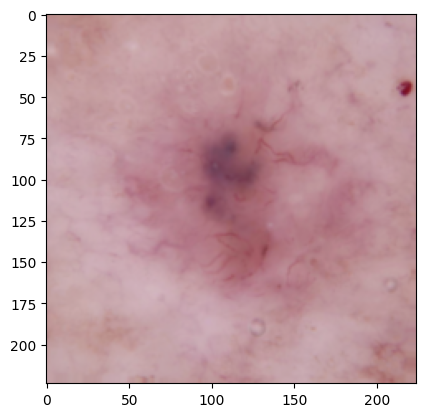

In [31]:
plt.imshow(batch["images"][0]);

## 5.4. Building Skin Cancer Classification Models

Here we examine four models:
- `SimpleCNN`: Light-weighted two-layer CNN.
- `ResNetFromScratch`: ResNet50.
- `FinetunedResNet`: transfer learning of pretrained ResNet50.
- `FinetunedHeadResNet`: Frozen pretrained ResNet50 with tailored prediction head.

### 5.4.1. Loading the Flax ResNet50 Model


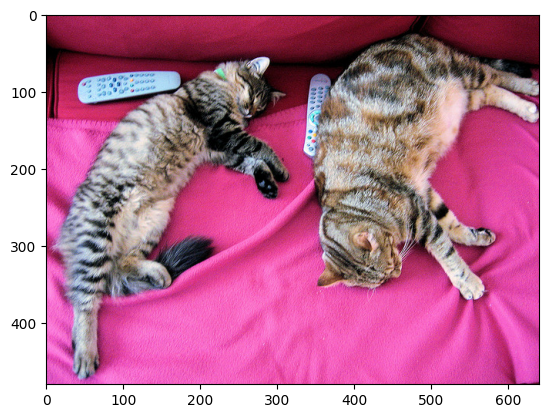

In [32]:
import requests

# Load the example image from the documentation.
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
plt.imshow(image);

The Hugging Face FlaxResNetModel provides a convenient way to import and use pretrained ResNet models, making it easy to fine-tune or extract features from standard models.

In [33]:
from transformers import AutoImageProcessor, FlaxResNetForImageClassification

resnet_model = FlaxResNetForImageClassification.from_pretrained(
  "microsoft/resnet-50"
)
image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")

In [ ]:
inputs = image_processor(images=image, return_tensors="jax")
# preprocessed the image
inputs.keys()

dict_keys(['pixel_values'])

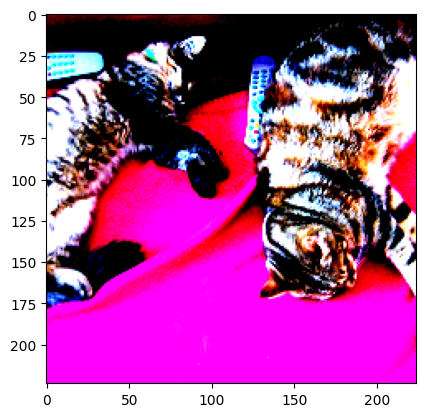

In [36]:
plt.imshow(jnp.transpose(inputs["pixel_values"], (0, 2, 3, 1))[0]);

jnp.transpose convert the channel dimension to the last dimension

In [42]:
jnp.transpose(inputs["pixel_values"], (0, 2, 3, 1)).shape

(1, 224, 224, 3)

In [37]:
outputs = resnet_model(**inputs)
logits = outputs.logits
predicted_class_idx = jnp.argmax(logits, axis=-1)
print(
  "Predicted class:", resnet_model.config.id2label[predicted_class_idx.item()]
)

Predicted class: tiger cat


### 5.4.2. Extracting the ResNet Backbone


ResNet50 is composed of 4 stages, each with multiple residual blocks (bottlenecks). 

| Stage | Structure | Calculation | Count |
| :--- | :--- | :--- | :--- |
| **Head (Stem)** | 1 Initial Convolution (7x7) | $1$ | **1** |
| **Stage 1** | 3 Residual Blocks (each has 3 layers) | $3 \times 3$ | **9** |
| **Stage 2** | 4 Residual Blocks (each has 3 layers) | $4 \times 3$ | **12** |
| **Stage 3** | 6 Residual Blocks (each has 3 layers) | $6 \times 3$ | **18** |
| **Stage 4** | 3 Residual Blocks (each has 3 layers) | $3 \times 3$ | **9** |
| **Tail** | 1 Fully Connected Layer (Classifier) | $1$ | **1** |
| **Total** | | | **50** |

    [ Image Input ]
        |
    [ Conv 1 (7x7) ]  -------------------------> Layer 1
        |
    [ Pool ]
        |
    [ Block 1 ] --+
    [ Block 2 ]   |--> 3 Blocks x 3 Layers ----> Layers 2 to 10
    [ Block 3 ] --+
        |
    [ Block 1 ] --+
    [ Block 2 ]   |
    [ Block 3 ]   |--> 4 Blocks x 3 Layers ----> Layers 11 to 22
    [ Block 4 ] --+
        |
    [ Block 1 ] --+
    ...        |--> 6 Blocks x 3 Layers ----> Layers 23 to 40
    [ Block 6 ] --+
        |
    [ Block 1 ] --+
    [ Block 2 ]   |--> 3 Blocks x 3 Layers ----> Layers 41 to 49
    [ Block 3 ] --+
        |
    [ Average Pool ]
        |
    [ FC Layer ]      -------------------------> Layer 50
        |
    [ Softmax Output ]

Each residual block can be further dissected into:

      Input
        |
    [Weight Layer]  <-- 1x1 Conv (Squash dimensions, downsample the input from last feature space expansion)
        |
    [Weight Layer]  <-- 3x3 Conv (Process features)  } "3 Layers"
        |                                            } inside 1 Block
    [Weight Layer]  <-- 1x1 Conv (Expand dimensions, upsample the feature space)
        |
        + <------------ Skip Connection (Identity) adds Input here
        |
      Output

Check [link](https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.ultralytics.com%2Fblog%2Fwhat-is-resnet-50-and-what-is-its-relevance-in-computer-vision&psig=AOvVaw3yUGg1cpPdF283Q7mvU4ks&ust=1763791472112000&source=images&cd=vfe&opi=89978449&ved=0CBUQjRxqFwoTCNjIkrXJgpEDFQAAAAAdAAAAABAS) for graphical illustration. Notice that there is a global average pooling that collapse the spatial resolution of all filters into a 2048-dimensional vector for FC layer prediction.

The pretrained ResNet50 contains:
- ResNet backbone
- Classifier head that map to one of ImageNet's 1000 categories

Extract the ResNet backbone with its parameters.

In [39]:
# whole model and its parameters
module, variables = resnet_model.module, resnet_model.params
# backbone and its parameters
backbone_module, backbone_vars = module.bind(variables).resnet.unbind()
# bind() associates the variables with the module to create a bound module instance
# then .resnet accesses the resnet submodule
# finally, unbind() detaches the parameters from the module, creating two separate objects

# backbone_module is now same as previously seen flax model that can be used for forward pass

In [40]:
outputs = backbone_module.apply(
  backbone_vars, jnp.transpose(inputs["pixel_values"], (0, 2, 3, 1)) # (0, 2, 3, 1) changes from (batch, channels, height, width) to (batch, height, width, channels)?
)
last_hidden_state = outputs.last_hidden_state
last_hidden_state.shape

(1, 2048, 7, 7)

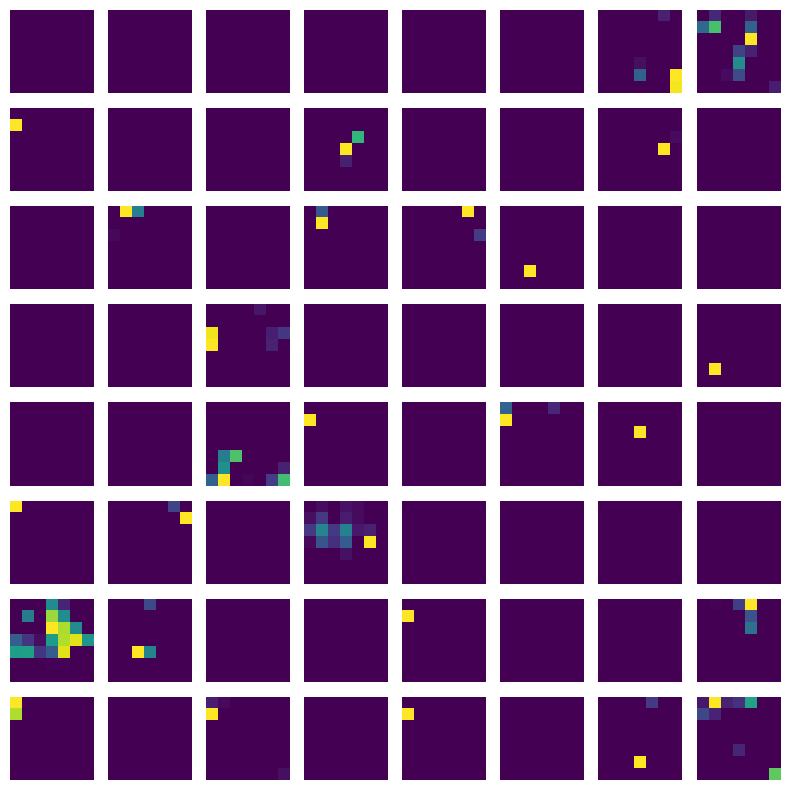

In [46]:
def display_feature_maps(feature_map, ncols=8):
  """Plot grid of the first 64 feature maps."""
  num_features = feature_map.shape[0]
  nrows = (num_features + ncols - 1) // ncols
  _, axes = plt.subplots(nrows, ncols, figsize=(ncols, nrows))
  axes = axes.flatten()

  for i, (ax, feature) in enumerate(zip(axes, feature_map)):
    ax.imshow(feature, cmap="viridis")
    ax.axis("off")

  plt.tight_layout()
  plt.show()


display_feature_maps(last_hidden_state[0, 0:64, ...])

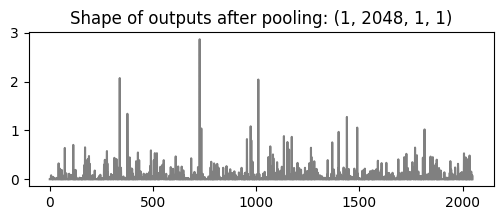

In [47]:
_, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.plot(np.squeeze(outputs.pooler_output), c="grey")
plt.title(f"Shape of outputs after pooling: {outputs.pooler_output.shape}");

### 5.4.3. Building the SkinLesionClassifierHead


Prediction head for num_class:
- `nn.Dense` 2048 -> 256 
- ReLu activation
- Dropout
- `nn.Dense` 256 -> 128
- Relu activation
- Dropout
- `nn.Dense` 128 -> num_class (logit)

In [48]:
from dlfb.cancer.model import SkinLesionClassifierHead

display([SkinLesionClassifierHead])

class SkinLesionClassifierHead(nn.Module):
  """Skin lesion classification MLP head."""

  num_classes: int
  dropout_rate: float

  @nn.compact
  def __call__(self, x, is_training: bool):
    x = nn.Dense(256, kernel_init=nn.initializers.xavier_uniform())(x)
    x = nn.relu(x)
    x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not is_training)
    x = nn.Dense(128, kernel_init=nn.initializers.xavier_uniform())(x)
    x = nn.relu(x)
    x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not is_training)
    x = nn.Dense(
      self.num_classes, kernel_init=nn.initializers.xavier_uniform()
    )(x)
    return x

### 5.4.4. Building Our Models
#### 5.4.4.1. SimpleCNN Model as a Baseline


In [49]:
from dlfb.cancer.model.cnn import SimpleCnn

display([SimpleCnn])
# SimpleCnn = Cnn + Prediction head

class SimpleCnn(nn.Module):
  """Simple CNN model with small convolutional backbone and classifier head."""

  num_classes: int
  dropout_rate: float = 0.0

  def setup(self):
    """Initializes the CNN backbone and classification head."""
    self.backbone = CnnBackbone()
    self.head = SkinLesionClassifierHead(self.num_classes, self.dropout_rate)

  @nn.compact
  def __call__(self, x, is_training: bool = False):
    """Applies the backbone and classifier head to the input."""
    x = self.backbone(x)
    x = self.head(x, is_training=is_training)
    return x

  def create_train_state(
    self, rng: jax.Array, dummy_input, tx
  ) -> TrainStateWithBatchNorm:
    """Creates the training state with initialized parameters."""
    rng, rng_init, rng_dropout = jax.random.split(rng, 3)
    variables = self.init(rng_init, dummy_input)
    state = TrainStateWithBatchNorm.create(
      apply_fn=self.apply,
      tx=tx,
      params=variables["params"],
      batch_stats=None,
      key=rng_dropout,
    )
    return state

In [50]:
from dlfb.cancer.model.cnn import CnnBackbone

display([CnnBackbone])

class CnnBackbone(nn.Module):
  """Compact convolutional feature extractor for image data."""

  @nn.compact
  def __call__(self, x):
    """Applies two conv-pool blocks and a dense layer to the input."""
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=256)(x)
    return x

In [52]:
from dlfb.cancer.model import TrainStateWithBatchNorm

display([TrainStateWithBatchNorm])
# intentionally left blank

class TrainStateWithBatchNorm(train_state.TrainState):
  """Train state that tracks batch statistics and a PRNG key."""

  batch_stats: dict | None
  key: jax.Array

#### 5.4.4.2. Building the ResNetFromScratch Model


In [54]:
from dlfb.cancer.model.resnet import ResNetFromScratch

display([ResNetFromScratch])
# Forward pass
# - backbone.pooler_output -> (1, 2048, 7, 7)
# - dimensionality reduction with global average pooling -> (1, 2048)
# - prediction head for num_class -> (1, num_class)

# transfer parameters
# - here we train from scratch, so no transfer learning, return randomely initialized parameters

# set trainable variables
# - here we train all parameters

class ResNetFromScratch(nn.Module):
  """ResNet model initialized from scratch with a custom classification head."""

  num_classes: int
  layers: int = 50
  dropout_rate: float = 0.0

  def setup(self):
    """Initializes the backbone and classification head."""
    self.backbone = PRETRAINED_RESNETS[self.layers].module
    self.head = SkinLesionClassifierHead(self.num_classes, self.dropout_rate)

  def __call__(self, x, is_training: bool = False):
    """Runs a forward pass through the model."""
    x = self.backbone(x, deterministic=not is_training).pooler_output
    x = jnp.squeeze(x, axis=(2, 3))
    x = self.head(x, is_training=is_training)
    return x

  def create_train_state(
    self, rng: jax.Array, dummy_input, tx
  ) -> TrainStateWithBatchNorm:
    """Initializes model parameters and optimizer state."""
    rng, rng_init, rng_dropout = jax.random.split(rng, 3)
    variables = self.init(rng_init, dummy_input, is_training=False)
    variables = self.transfer_parameters(variables)
    tx = self.set_trainable_parameters(tx, variables)
    state = TrainStateWithBatchNorm.create(
      apply_fn=self.apply,
      tx=tx,
      params=variables["params"],
      batch_stats=variables["batch_stats"],
      key=rng_dropout,
    )
    return state

  def transfer_parameters(_, variables):
    """Returns variables unchanged (no transfer learning)."""
    return variables

  @staticmethod
  def set_trainable_parameters(tx, _):
    """Returns optimizer configuration with all parameters trainable."""
    return tx

# 6. Dictionary of pretrained ResNet models from Hugging Face.
#### 6.0.0.1. Building the FinetunedResNet Model


A subclass of ResNetFromScratch, with one distinction: transfer pretrained parameters as initial weights.

In [57]:
from dlfb.cancer.model.resnet import FinetunedResNet

display([FinetunedResNet])
# override the transfer_parameters method
# copies over both the backbone’s weights and its batch normalization statistics.
# the prediction head remains randomly initialized

class FinetunedResNet(ResNetFromScratch):
  """ResNet model with pretrained weights and full fine-tuning."""

  def transfer_parameters(self, variables):
    """Replaces model parameters with pretrained ResNet weights."""
    resnet_variables = PRETRAINED_RESNETS[self.layers].params
    variables["params"]["backbone"] = resnet_variables["params"]
    variables["batch_stats"]["backbone"] = resnet_variables["batch_stats"]
    return variables

#### 6.0.0.2. Freezing the Backbone with FinetunedHeadResNet


In [58]:
from dlfb.cancer.model.resnet import FinetunedHeadResNet

display([FinetunedHeadResNet])
# a subclass of FunetunedResNet, with one distinction: freeze ResNet pretrained parameters
# override the set_trainable_variables method

class FinetunedHeadResNet(FinetunedResNet):
  """ResNet model with a frozen backbone and trainable classification head."""

  @staticmethod
  def set_trainable_parameters(tx, variables):
    """Freezes backbone parameters and trains only the classification head."""
    return optax.multi_transform(
      transforms={"trainable": tx, "frozen": optax.set_to_zero()},
      param_labels=traverse_util.path_aware_map(
        lambda path, _: "frozen" if "backbone" in path else "trainable",
        variables["params"],
      ),
    )

#### 6.0.0.3. More Customization Options


`PartiallyFinetunedResNet` applies:
- A standard learning rate to the classification head and late-stage backbone layers
- A reduced learning rate to intermediate layers (i.e., stages/3) 
- A complete freezing of the early backbone layers

In [19]:
from dlfb.cancer.model.resnet import PartiallyFinetunedResNet

display([PartiallyFinetunedResNet])

class PartiallyFinetunedResNet(FinetunedResNet):
  """ResNet model with selective fine-tuning of deeper layers."""

  @staticmethod
  def set_trainable_parameters(tx, variables):
    """Freezes early layers, fine-tunes other layers at variable LR."""

    def label_fn(path, _):
      joined = "/".join(path)
      if "backbone" in path:
        if "stages/3" in joined:
          return "reduced_lr"
        return "frozen"
      return "trainable"

    return optax.multi_transform(
      transforms={
        "trainable": tx,
        "reduced_lr": optax.adam(learning_rate=1e-5),
        "frozen": optax.set_to_zero(),
      },
      param_labels=traverse_util.path_aware_map(label_fn, variables["params"]),
    )

## 6.1. Training the Models
### 6.1.1. The Training Loop


In [59]:
from dlfb.cancer.train import train

display([train])

@restorable
def train(
  state: TrainStateWithBatchNorm,
  rng: jax.Array,
  dataset_splits: dict[str, Dataset],
  num_steps: int,
  batch_size: int,
  preprocessor: Callable = crop,
  sampler: Callable = repeating_sampler,
  augmentor: Callable = None,
  eval_every: int = 10,
) -> tuple[TrainStateWithBatchNorm, dict]:
  """Trains a model using the provided dataset splits and logs metrics."""
  # Setup with metrics logger and classes numbers.
  num_classes = dataset_splits["train"].num_classes
  metrics = MetricsLogger()

  # Get train batch iterator from which to take batches.
  rng, rng_train, rng_eval = jax.random.split(rng, 3)
  train_batcher = BatchHandler(preprocessor, sampler, augmentor)
  train_batches = train_batcher.get_batches(
    dataset_splits["train"], batch_size, rng_train
  )

  steps = tqdm(range(num_steps))  # Steps with progress bar.
  for step in steps:
    steps.set_description(f"Step {step + 1}")

    rng, rng_dropout = jax.random.split(rng, 2)
    train_batch = next(train_batches)
    state, batch_metrics = train_step(
      state, train_batch, rng_dropout, num_classes
    )
    metrics.log_step(split="train", **batch_metrics)

    if step % eval_every == 0:
      for batch in BatchHandler(preprocessor).get_batches(
        dataset_splits["valid"], batch_size, rng_eval
      ):
        batch_metrics = eval_step(state, batch, num_classes)
        metrics.log_step(split="valid", **batch_metrics)
      metrics.flush(step=step)

    steps.set_postfix_str(metrics.latest(["loss"]))

  return state, metrics.export()

#### 6.1.1.1. The Training Step


In [63]:
from dlfb.cancer.train import train_step

display([train_step])
# softmax_cross_entropy_with_integer_labels to compute loss for multi-class classification
# mean over the batch

@partial(jax.jit, static_argnums=(3,))
def train_step(
  state: TrainStateWithBatchNorm,
  batch: dict[str, list[Any]],
  rng_dropout: jax.Array,
  num_classes: int,
) -> tuple[TrainStateWithBatchNorm, dict[str, jax.Array]]:
  """Performs a single training step and returns updated state and metrics."""

  def calculate_loss(params, images, labels):
    variables, kwargs = {"params": params}, {"mutable": []}
    if state.batch_stats is not None:
      variables.update({"batch_stats": state.batch_stats})
      kwargs.update({"mutable": ["batch_stats"]})
    logits, updates = state.apply_fn(
      variables,
      x=images,
      is_training=True,
      rngs={"dropout": rng_dropout},
      **kwargs,
    )
    loss = optax.softmax_cross_entropy_with_integer_labels(
      logits, labels
    ).mean()
    return loss, (logits, updates)

  grad_fn = jax.value_and_grad(calculate_loss, has_aux=True)
  (loss, (logits, updates)), grads = grad_fn(
    state.params, batch["images"], batch["labels"]
  )
  state = state.apply_gradients(grads=grads)
  if state.batch_stats is not None:
    state = state.replace(batch_stats=updates["batch_stats"])

  metrics = {
    "loss": loss,
    **compute_metrics(batch["labels"], logits, num_classes),
  }

  return state, metrics

#### 6.1.1.2. The Evaluation Step


In [64]:
from dlfb.cancer.train import eval_step

display([eval_step])

@partial(jax.jit, static_argnums=(2,))
def eval_step(
  state: TrainStateWithBatchNorm, batch: dict[str, Any], num_classes: int
):
  """Evaluates model performance on a batch and computes metrics."""
  variables, kwargs = {"params": state.params}, {}
  if state.batch_stats is not None:
    variables.update({"batch_stats": state.batch_stats})
    kwargs.update({"mutable": False})

  logits = state.apply_fn(
    variables, x=batch["images"], is_training=False, **kwargs
  )
  loss = optax.softmax_cross_entropy_with_integer_labels(
    logits, batch["labels"]
  ).mean()

  metrics = {
    "loss": loss,
    **compute_metrics(batch["labels"], logits, num_classes),
  }
  return metrics

#### 6.1.1.3. Evaluation Metrics


In [66]:
from dlfb.cancer.train import compute_metrics

display([compute_metrics])
# here we use weighted recall and weighted precision for multi-class classification (recall is prioritized)

@partial(jax.jit, static_argnums=(2,))
def compute_metrics(
  y_true: jax.Array, logits: jax.Array, n_labels: jax.Array
) -> dict[str, jax.Array]:
  """Computes weighted precision and recall metrics from logits and labels."""
  y_scores = jax.nn.softmax(logits)
  y_pred = jnp.argmax(y_scores, axis=1)
  metrics = {
    "recall_weighted": recall_score(
      y_true, y_pred, n_labels, average="weighted"
    ),
    "precision_weighted": precision_score(
      y_true, y_pred, n_labels, average="weighted"
    ),
  }
  return metrics

#### 6.1.1.4. Faster Evaluation Metrics
### 6.1.2. Creating the Multiclass Dataset


Use the previously built DatasetBuilder to prepare multi-class dataset

In [ ]:
from dlfb.cancer.dataset.preprocessors import skew, crop, resnet

rng = jax.random.PRNGKey(seed=42)
rng, rng_dataset, rng_init, rng_train = jax.random.split(rng, num=4)

dataset_splits = DatasetBuilder(
  data_dir=assets("cancer/datasets/raw"),
).build(
  rng=rng_dataset,
  preprocessors=[skew, crop, resnet], # skew alters the aspect ratio to fit into square without cropping
  image_size=(224, 224, 3),
  splits={"train": 0.70, "valid": 0.20, "test": 0.10},
)

num_classes = dataset_splits["train"].num_classes

### 6.1.3. Training the Baseline Model


In [ ]:
import optax

from dlfb.cancer.train.handlers.samplers import repeating_sampler
from dlfb.cancer.utils import decay_mask

learning_rate = 0.001
num_steps = 2000

state, metrics = train(
  state=SimpleCnn(num_classes=num_classes).create_train_state(
    rng=rng_init,
    dummy_input=dataset_splits["train"].get_dummy_input(),
    tx=optax.adamw(learning_rate, weight_decay=0.0, mask=decay_mask),
  ),
  rng=rng_train,
  dataset_splits=dataset_splits,
  num_steps=num_steps,
  batch_size=32,
  preprocessor=crop, # only crop for training, no skew or resnet preprocessing
  sampler=repeating_sampler, # simple random sampling with replacement, doesn't guarantee class balance
  augmentor=None, # no augmentation
  eval_every=100,
  store_path=assets("cancer/models/baseline"),
)

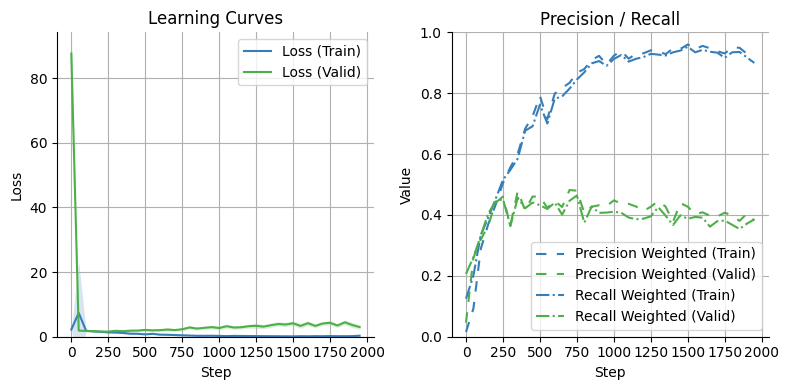

In [69]:
from dlfb.cancer.inspect import plot_learning

plot_learning(metrics);

In [ ]:
from dlfb.cancer.inspect import plot_classified_images
from dlfb.cancer.train import get_predictions

predictions = get_predictions(state, dataset_splits["valid"], resnet, 32)
plot_classified_images(
  predictions, dataset_splits["valid"], crop, max_images=8
)

The model, as baseline, didn't perform that well:
- Many misclassified entries (off-diagonal), especially for less common classes.
- Melanoma cases were usually misclassified as nevi or other benign categories (low recall).

### 6.1.4. Training the ResNetFromScratch Model


In [71]:
state, metrics = train(
  state=ResNetFromScratch(num_classes=num_classes).create_train_state(
    rng=rng_init,
    dummy_input=dataset_splits["train"].get_dummy_input(),
    tx=optax.adamw(learning_rate, weight_decay=0.0, mask=decay_mask),
  ),
  rng=rng_train,
  dataset_splits=dataset_splits,
  num_steps=num_steps,
  batch_size=32,
  preprocessor=crop,  # No preprocessing.
  sampler=repeating_sampler,  # No balancing.
  augmentor=None,  # No augmentation.
  eval_every=100,
  store_path=assets("cancer/models/resnet_from_scratch"),
)

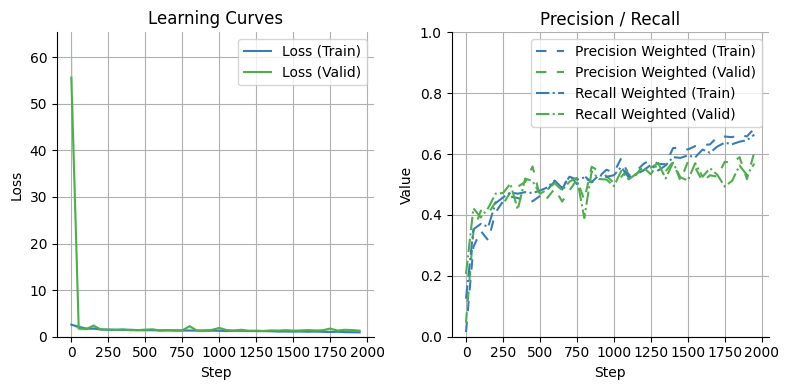

In [72]:
plot_learning(metrics);

/content/dlfb-clone/src/dlfb/cancer/inspect.py:80: RuntimeWarning: invalid value encountered in divide
  precision = np.diag(cm) / np.sum(cm, axis=0)


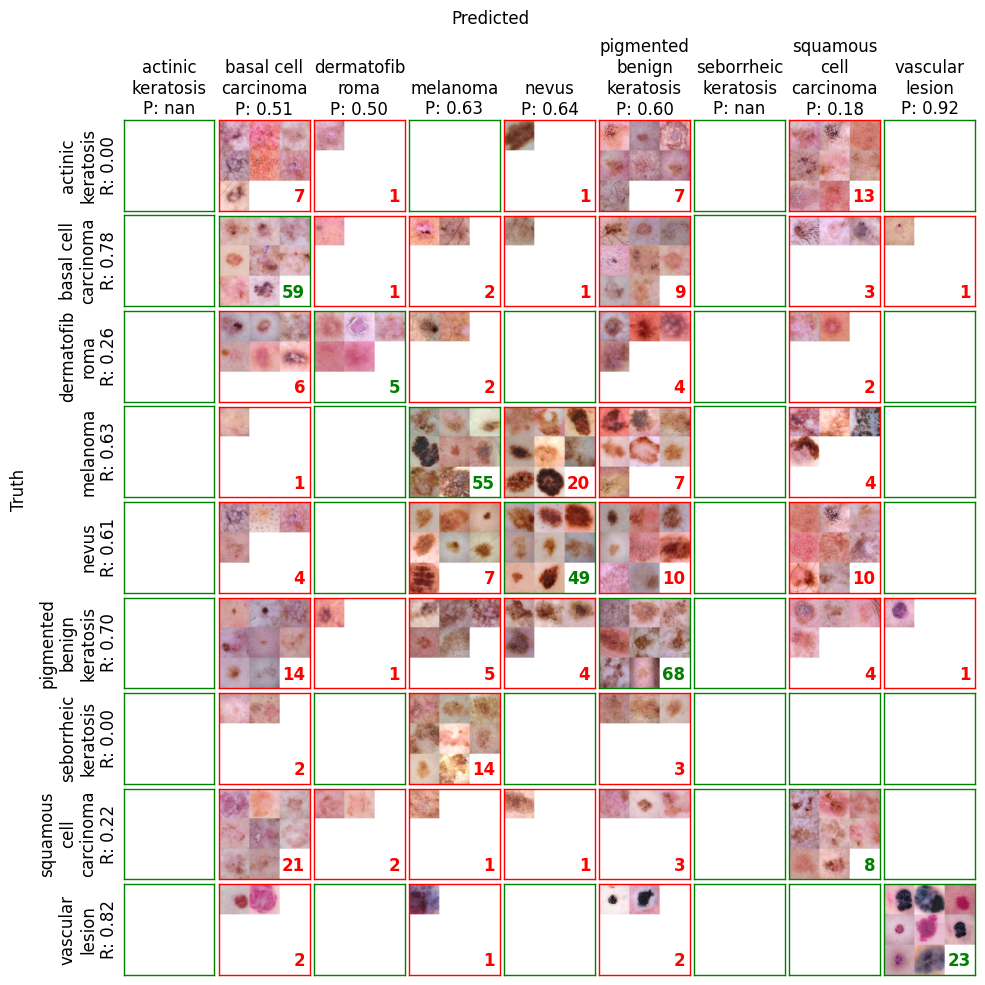

In [73]:
predictions = get_predictions(state, dataset_splits["valid"], resnet, 32)
plot_classified_images(
  predictions, dataset_splits["valid"], crop, max_images=8
);

### 6.1.5. Training the FinetunedHeadResNet Model


In [74]:
from dlfb.cancer.dataset.preprocessors import resnet

display(
  [
    'IMAGE_PROCESSOR = AutoImageProcessor.from_pretrained("microsoft/resnet-50")',
    resnet
  ]
)

IMAGE_PROCESSOR = AutoImageProcessor.from_pretrained("microsoft/resnet-50")

def resnet(image: jax.Array) -> jax.Array:
  """Preprocess from pretrained model with transpose for compatibility."""
  image = IMAGE_PROCESSOR(image, return_tensors="jax", do_rescale=True)
  image = image["pixel_values"]
  image = convert_nchw_to_nhwc(image)
  return image

In [ ]:
state, metrics = train(
  state=FinetunedHeadResNet(num_classes=num_classes).create_train_state(
    rng=rng_init,
    dummy_input=dataset_splits["train"].get_dummy_input(),
    tx=optax.adamw(learning_rate, weight_decay=0.0, mask=decay_mask),
  ),
  rng=rng_train,
  dataset_splits=dataset_splits,
  num_steps=num_steps,
  batch_size=32,
  preprocessor=resnet, # apply resnet preprocessing so that images are compatible with pretrained ResNet weights
  sampler=repeating_sampler, # simple random sampling with replacement, doesn't guarantee class balance
  augmentor=None, # no augmentation
  eval_every=100,
  store_path=assets("cancer/models/resnet_just_head"),
)

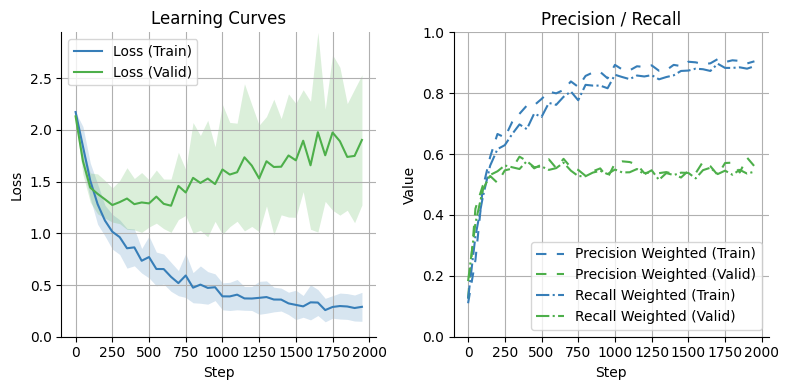

In [76]:
plot_learning(metrics);

Training only the classification head doesn’t provide enough flexibility for the model to properly adapt to our dataset.

### 6.1.6. Training the `FinetunedResNet` Model (transfer learning)


In [78]:
state, metrics = train(
  state=FinetunedResNet(num_classes=num_classes).create_train_state(
    rng=rng_init,
    dummy_input=dataset_splits["train"].get_dummy_input(),
    tx=optax.adamw(learning_rate, weight_decay=0.0, mask=decay_mask),
  ),
  rng=rng_train,
  dataset_splits=dataset_splits,
  num_steps=num_steps,
  batch_size=32,
  preprocessor=resnet, 
  sampler=repeating_sampler,
  augmentor=None,
  eval_every=100,
  store_path=assets("cancer/models/resnet50_basic"),
)

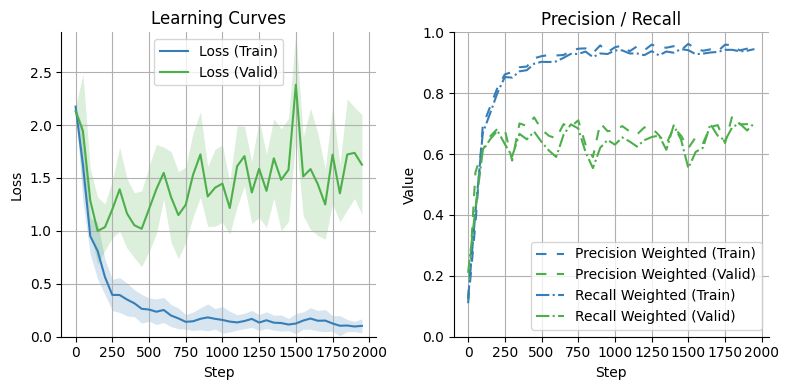

In [80]:
plot_learning(metrics);

### 6.1.7. Optimizing the `FinetunedResNet` Model (transfer learning)

We improve the currently best model via:
- Tuning learning rate to accelerate convergence
- Data augmentation
- High-rate dropout in prediction head to avoid overfitting

#### 6.1.7.1. Learning Rate Schedule


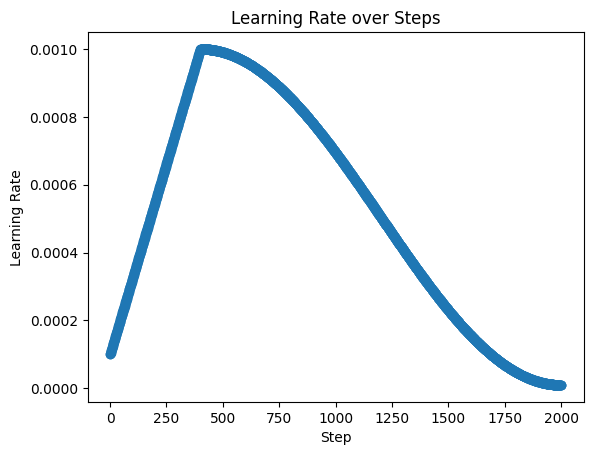

In [81]:
import optax

learning_rate = 0.001
num_steps = 2000

warmup_cosine_decay_scheduler = optax.warmup_cosine_decay_schedule(
  init_value=0.0001,
  peak_value=learning_rate,
  end_value=0.00001,
  warmup_steps=int(num_steps * 0.2),
  decay_steps=num_steps,
)

lrs = [warmup_cosine_decay_scheduler(i) for i in range(num_steps)]

plt.scatter(range(num_steps), lrs)
plt.title("Learning Rate over Steps")
plt.ylabel("Learning Rate")
plt.xlabel("Step");

#### 6.1.7.2. Data Augmentation
#### 6.1.7.3. Regularization via Dropout and `adamw`
### 6.1.8. Training the Optimized `FinetunedResNet` Model


In [ ]:
state, metrics = train(
  state=FinetunedResNet(
    num_classes=num_classes, dropout_rate=0.7
  ).create_train_state(
    rng=rng_init,
    dummy_input=dataset_splits["train"].get_dummy_input(),
    tx=optax.adamw(
      warmup_cosine_decay_scheduler, weight_decay=1e-4, mask=decay_mask 
    ),
    # changeable learning rate and weight decay
    # the important "decay_mask" to avoid weight decay on batch norm parameters and bias terms (explained in textbook)
  ),
  rng=rng_train,
  dataset_splits=dataset_splits,
  num_steps=num_steps,
  batch_size=32,
  preprocessor=resnet, # apply resnet preprocessing so that images are compatible with pretrained ResNet weights
  sampler=repeating_sampler, # simple random sampling with replacement, doesn't guarantee class balance
  augmentor=rich_augmentor, # apply data augmentation
  eval_every=100,
  store_path=assets("cancer/models/resnet50_optimized"),
)

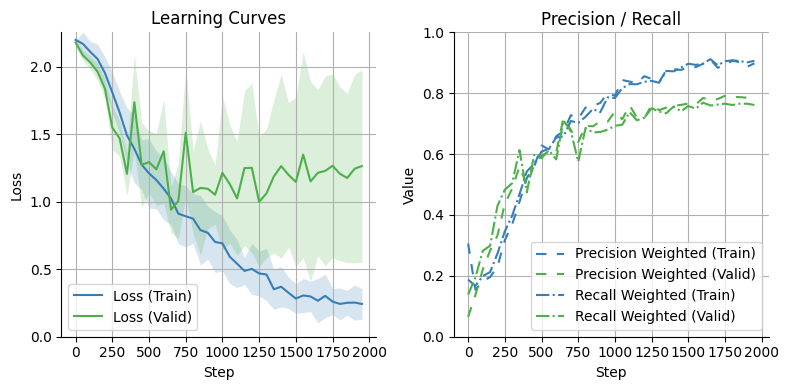

In [83]:
plot_learning(metrics);

/content/dlfb-clone/src/dlfb/cancer/inspect.py:80: RuntimeWarning: invalid value encountered in divide
  precision = np.diag(cm) / np.sum(cm, axis=0)


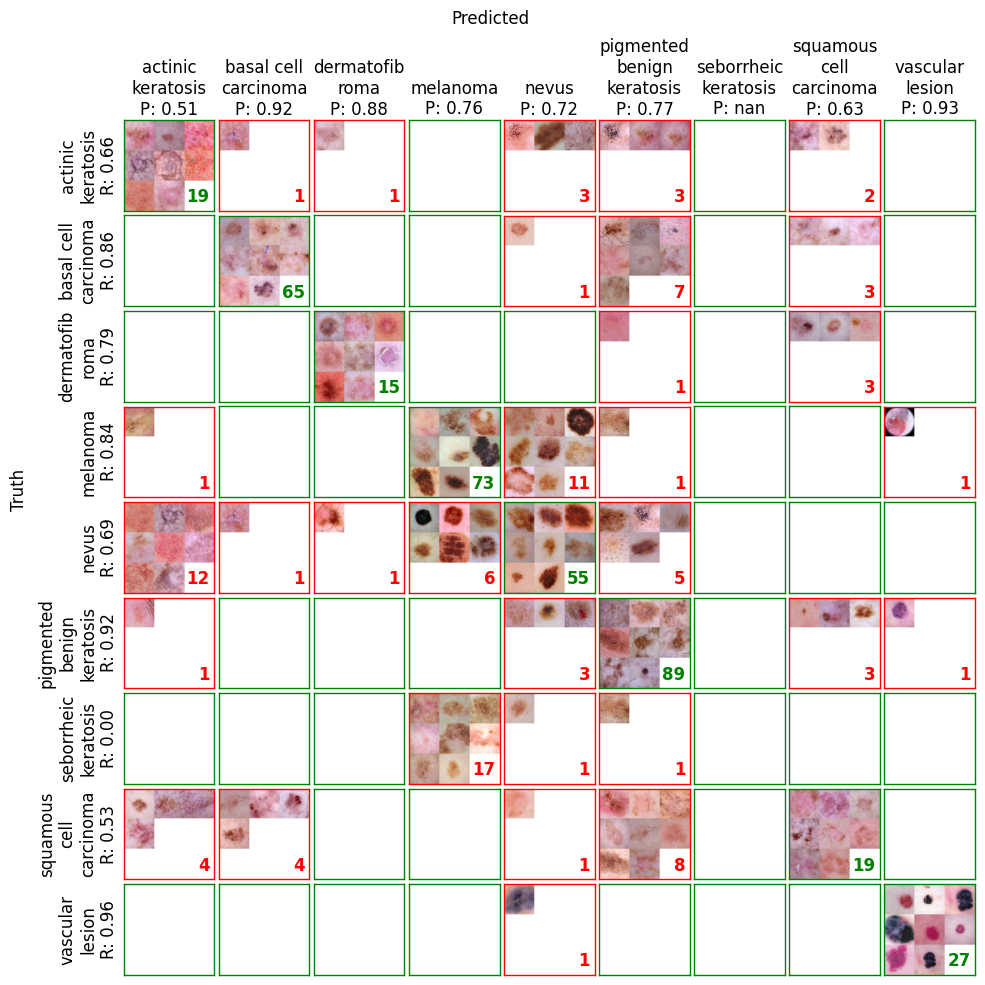

In [84]:
predictions = get_predictions(state, dataset_splits["valid"], resnet, 32)
plot_classified_images(
  predictions, dataset_splits["valid"], crop, max_images=8
);

### 6.1.9. Further Improving the Model


## 6.2. Summary
